# The Street View House Numbers (SVHN) Dataset

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. The dataset and more information can be founded [`here`](http://ufldl.stanford.edu/housenumbers/).

## Loading data and libraries

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from urllib import urlretrieve
from scipy.io import loadmat
from __future__ import print_function

from helpers import display_sample_images, preprocess_images, one_hot_encode, batch_creator

%matplotlib inline
tf.reset_default_graph()

In [2]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile('./tensorflow_vgg/vgg16.npy'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            './tensorflow_vgg/vgg16.npy',
            pbar.hook)

from tensorflow_vgg import vgg16

## Load the dataset

In [3]:
if not os.path.isfile('../data/train_32x32.mat'):
    os.mkdir('../data')
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Dataset') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            '../data/train_32x32.mat',
            pbar.hook)

svhn_data = loadmat('../data/train_32x32.mat')
print('Data loaded!')

Data loaded!


## Understanding the dataset

In [4]:
print(type(svhn_data))
print(svhn_data.keys())

<type 'dict'>
['y', 'X', '__version__', '__header__', '__globals__']


In [5]:
features = svhn_data['X']
labels = svhn_data['y']

print('X: {} ({} x {} x {}) images'.format(features.shape[3], features.shape[0],
                                           features.shape[1], features.shape[2]))
print('y: {} ({}) labels'.format(labels.shape[0], labels.shape[1]))
print('First 30 labels: {}'.format(labels[:30].reshape((1,-1))))
print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))

X: 73257 (32 x 32 x 3) images
y: 73257 (1) labels
First 30 labels: [[1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8 1 6 2 3 6 3 4 2 5 8]]
Label Counts: {1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 9: 4659, 10: 4948}


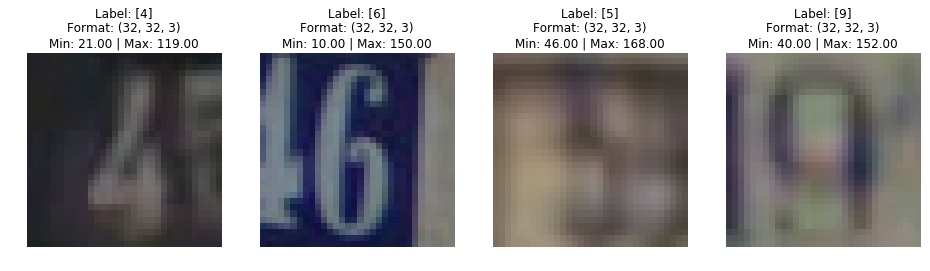

In [6]:
display_sample_images(features, labels, 4)

## Building the Neural Net

In [7]:
batch_size = 128
codes = None

In [ ]:
with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    images = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope('content_vgg'):
        vgg.build(images)
    
    for batch, _ in batch_creator(features, labels, batch_size):
        processed_batch = preprocess_images(batch)
        feed_dict = {images: processed_batch}
        codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
        if codes is None:
            codes = codes_batch
        else:
            codes = np.concatenate((codes, codes_batch))

/Volumes/MyPassport/Udacity/machine-learning/mlnd_capstone/project/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 1s


In [ ]:
print(codes.shape)